source https://discourse.pymc.io/t/specifying-hierarchical-binomial-model-when-individuals-have-varying-numbers-of-trials/3889

https://people.duke.edu/~ccc14/sta-663/PyMC2.html

# Hierarchical Bayesian model

We have 5 coins from machine A and 1 coin from machine B, we want to assess if machine A and machine B have the same manufacturing parameters.

# /!\ to do: generate the data from gaussian distribution, check different model designs. /!\

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pymc as pm 
import pandas as pd
import arviz as az

def plot_style(figsize=(12, 6), labelsize=20, spine_left=False, spine_bottom=True, titlesize=24, ticklabelsize=14, **kwargs):
    basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
        'axes.spines.bottom': spine_bottom,
       'axes.spines.right': False,
       'axes.spines.left': spine_left,
    }
    basic_style.update(kwargs)
    return plt.rc_context(rc=basic_style)

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Experiment 1: assumes that the coin flips are done using the same coin
In the anomaly project, this corresponds to having bad samples from past sessions drawn from a common distribution

In [126]:
# 5 coins from machine A
common_p = [0.4]*5
# common_p = [0.4, 0.5, 0.45, 0.35, 0.4]
coin_data_A = [
    np.random.binomial(1, common_p[0], 40),
    np.random.binomial(1, common_p[1], 70),
    np.random.binomial(1, common_p[2], 55),
    np.random.binomial(1, common_p[3], 60),
    np.random.binomial(1, common_p[4], 45),
]

n_coins_A = len(coin_data_A)
print('tosses for 5 coins')
print(coin_data_A)

# coin index of each toss
coin_data_A_index = [[i]*len(coin) for i, coin in enumerate(coin_data_A)]
print('coin index for the tosses')
print(coin_data_A_index)

# flatten the data
coin_data_A = np.hstack(coin_data_A)
coin_data_A_index = np.hstack(coin_data_A_index)

nvect_A, pvect_A = [], [] 
for i in np.unique(coin_data_A_index): 
    idx = coin_data_A_index == i 
    nvect_A.append(idx.sum()) 
    pvect_A.append(coin_data_A[idx].sum())
pvect_A, nvect_A

tosses for 5 coins
[array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1]), array([1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0]), array([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0]), array([0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]), array([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0])]
coin index for the tosses
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 

([16, 29, 23, 24, 16], [40, 70, 55, 60, 45])

In [127]:
# 1 coin from machine B
coin_data_B = [
    np.random.binomial(1, 0.7, 75),
]
n_coins_B = len(coin_data_B)
print('tosses for 1 coin')
print(coin_data_B)

# coin index of each toss
coin_data_B_index = [[i]*len(coin) for i, coin in enumerate(coin_data_B)]
print('coin index for the tosses')
print(coin_data_B_index)

# flatten the data
coin_data_B = np.hstack(coin_data_B)
coin_data_B_index = np.hstack(coin_data_B_index)

nvect_B, pvect_B = [], [] 
for i in np.unique(coin_data_B_index): 
    idx = coin_data_B_index == i 
    nvect_B.append(idx.sum()) 
    pvect_B.append(coin_data_B[idx].sum())
pvect_B, nvect_B

tosses for 1 coin
[array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1])]
coin index for the tosses
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


([54], [75])

## Model 1: the draws for A are coming from a common distribution
This matches how the data was actually generated.

In [128]:
with pm.Model() as model_1:
    ### machine A
    ## prior p for each coin
    # p_A = pm.Beta('p_A', alpha=2, beta=4, shape=1)
    p_A = pm.Uniform('p_A', lower=0, upper=1, shape=1) # non-informative prior

    ## coin tosses
    heads_A = pm.Binomial('heads_A', n=nvect_A, p=p_A, observed=pvect_A)
    
    ### machine B
    ## prior p for single coin
    # p_B = pm.Beta('p_B', alpha=2, beta=4, shape=1)
    p_B = pm.Uniform('p_B', lower=0, upper=1, shape=1) # non-informative prior
    
    ## coin tosses
    heads_B = pm.Binomial('heads_B', n=nvect_B, p=p_B, observed=pvect_B)
    
    ## difference between the two coins
    delta_p = pm.Deterministic('delta_p', p_A-p_B)

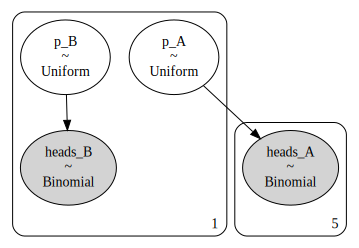

In [129]:
pm.model_to_graphviz(model_1)

In [130]:
with model_1:
    trace_1 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_A, p_B]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.


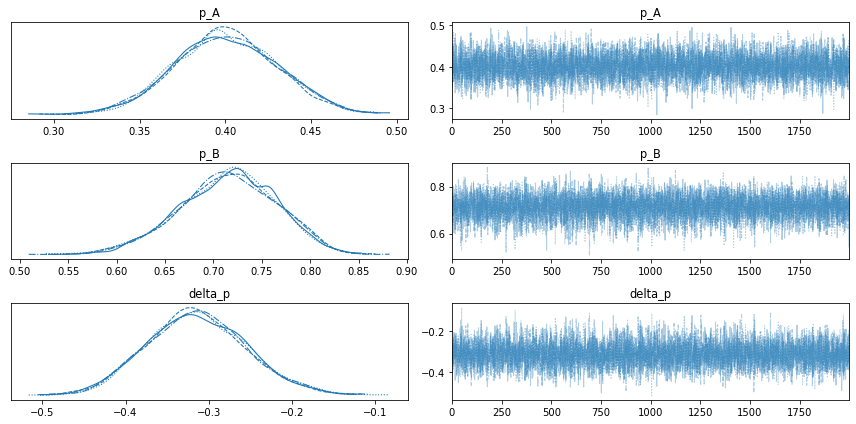

In [131]:
az.plot_trace(trace_1)
plt.tight_layout()
plt.draw()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

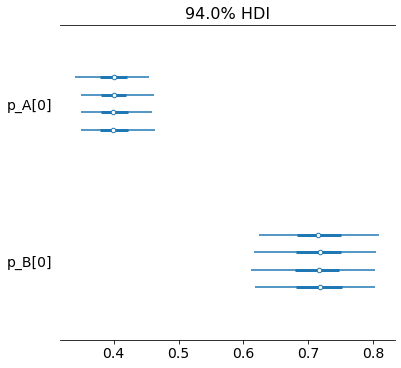

In [132]:
# 94% Highest density interverl (HDI) 
az.plot_forest(trace_1, var_names=['p_A', 'p_B'])

## Model 2: the draws for A are coming from distributions with different parameter values. 
This does not match how the data was generated.

In [133]:
with pm.Model() as model_2:
    ### machine A
    ## prior p for each coin
    # p_A = pm.Beta('p_A', alpha=2, beta=4, shape=n_coins_A)
    p_A = pm.Uniform('p_A', lower=0, upper=1, shape=n_coins_A) # non-informative prior

    ## coin tosses
    heads_A = pm.Binomial('heads_A', n=nvect_A, p=p_A, observed=pvect_A)
    
    ### machine B
    ## prior p for single coin
    # p_B = pm.Beta('p_B', alpha=2, beta=4, shape=1)
    p_B = pm.Uniform('p_B', lower=0, upper=1, shape=1) # non-informative prior
    
    ## coin tosses
    heads_B = pm.Binomial('heads_B', n=nvect_B, p=p_B, observed=pvect_B)
    
    ## difference between the two coins
    delta_p = pm.Deterministic('delta_p', p_A-p_B)

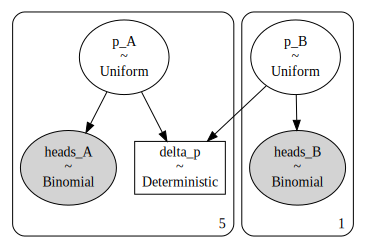

In [134]:
pm.model_to_graphviz(model_2)

In [135]:
with model_2:
    trace_2 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_A, p_B]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.


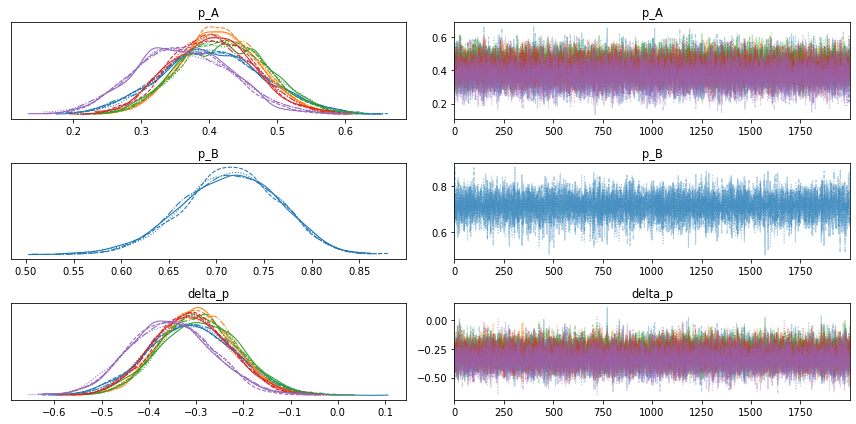

In [136]:
az.plot_trace(trace_2)
plt.tight_layout()
plt.draw()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

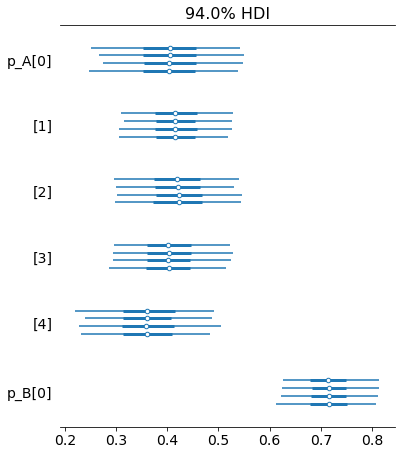

In [137]:
az.plot_forest(trace_2, var_names=['p_A', 'p_B'])

## Model 3: the draws for A are coming from distributions with different parameter values, but those distributions are coming from a common generation process

In [138]:
with pm.Model() as model_3:
    ## hyperpriors for machine A and machine B
    alpha = pm.HalfNormal('alpha', 5.0, shape=2) 
    beta = pm.HalfNormal('beta', 5.0, shape=2) 
    
    ### machine A
    ## prior p for each coin
    p_A = pm.Beta("p_A", alpha=alpha[0], beta=beta[0], shape=n_coins_A)

    ## coin tosses
    heads_A = pm.Binomial('heads_A', n=nvect_A, p=p_A, observed=pvect_A)
    
    ### machine B
    ## prior p for single coin
    p_B = pm.Beta("p_B", alpha=alpha[1], beta=beta[1], shape=n_coins_B)
    
    ## coin tosses
    heads_B = pm.Binomial('heads_B', n=nvect_B, p=p_B, observed=pvect_B)
    
    ## difference between the parameters of machine A and machine B
    delta_alpha = pm.Deterministic('delta_alpha', alpha[0]-alpha[1])
    delta_beta = pm.Deterministic('delta_beta', beta[0]-beta[1])     

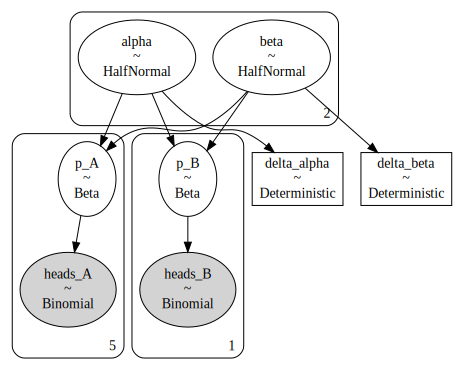

In [139]:
pm.model_to_graphviz(model_3)

In [140]:
with model_3:
    trace_3 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, p_A, p_B]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6844, but should be close to 0.8. Try to increase the number of tuning steps.


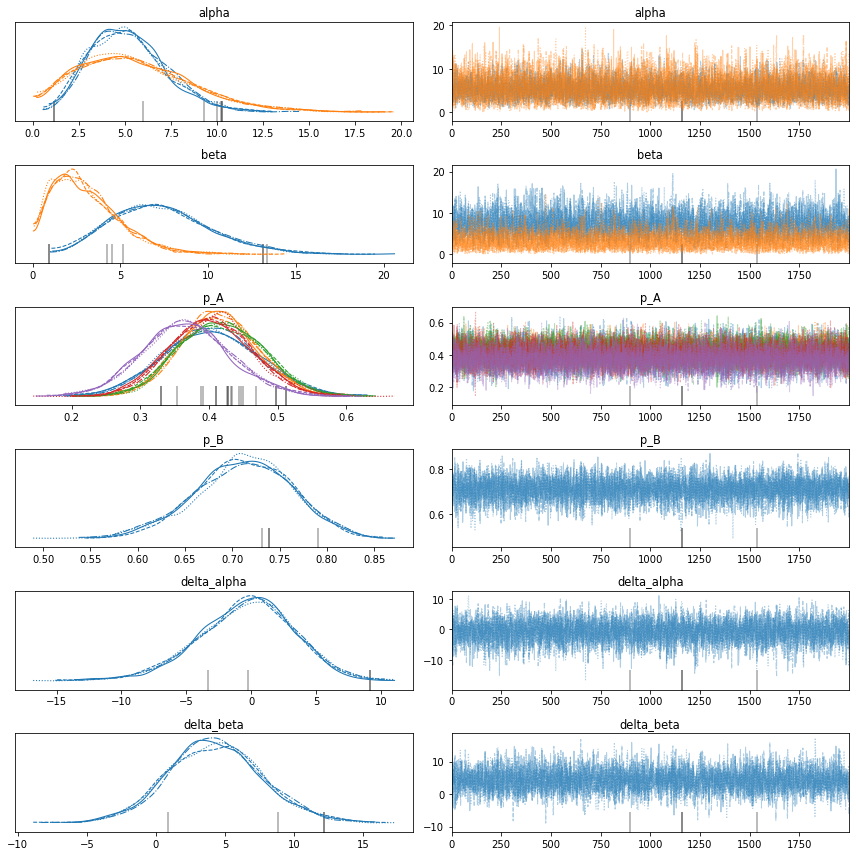

In [141]:
az.plot_trace(trace_3)
plt.tight_layout()
plt.draw()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

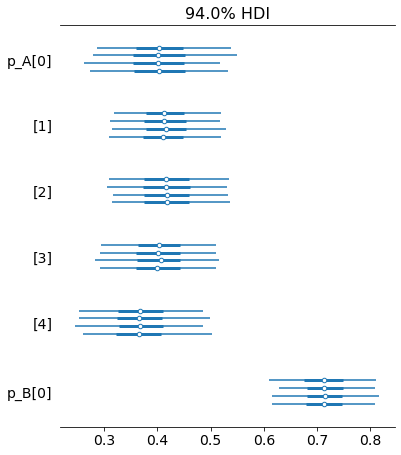

In [142]:
az.plot_forest(trace_3, var_names=['p_A', 'p_B'])

## Model 4: like model 1, ie same $p$ for coins A, but with a hyperprior
so we can compare, pA with pB, or parameters for machine A with parameters for machine B\

In [143]:
with pm.Model() as model_4:
    ## hyperpriors for machine A and machine B
    alpha = pm.HalfNormal('alpha', 5.0, shape=2) 
    beta = pm.HalfNormal('beta', 5.0, shape=2) 
    
    ### machine A
    ## prior p for each coin
    p_A = pm.Beta("p_A", alpha=alpha[0], beta=beta[0], shape=1)

    ## coin tosses
    heads_A = pm.Binomial('heads_A', n=nvect_A, p=p_A, observed=pvect_A)
    
    ### machine B
    ## prior p for single coin
    p_B = pm.Beta("p_B", alpha=alpha[1], beta=beta[1], shape=1)
    
    ## coin tosses
    heads_B = pm.Binomial('heads_B', n=nvect_B, p=p_B, observed=pvect_B)
    
    ## difference between the parameters of machine A and machine B
    delta_alpha = pm.Deterministic('delta_alpha', alpha[0]-alpha[1])
    delta_beta = pm.Deterministic('delta_beta', beta[0]-beta[1])  
    
    ## difference between p_A and p_B
    delta_p = pm.Deterministic('delta_p', p_A - p_B)

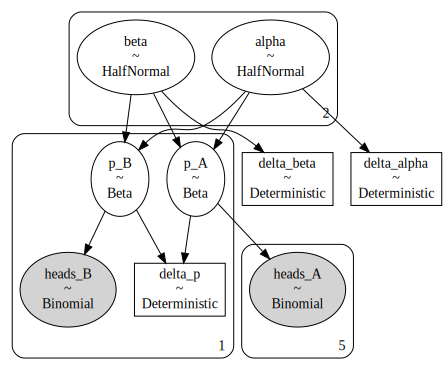

In [144]:
pm.model_to_graphviz(model_4)

In [145]:
with model_4:
    trace_4 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, p_A, p_B]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.


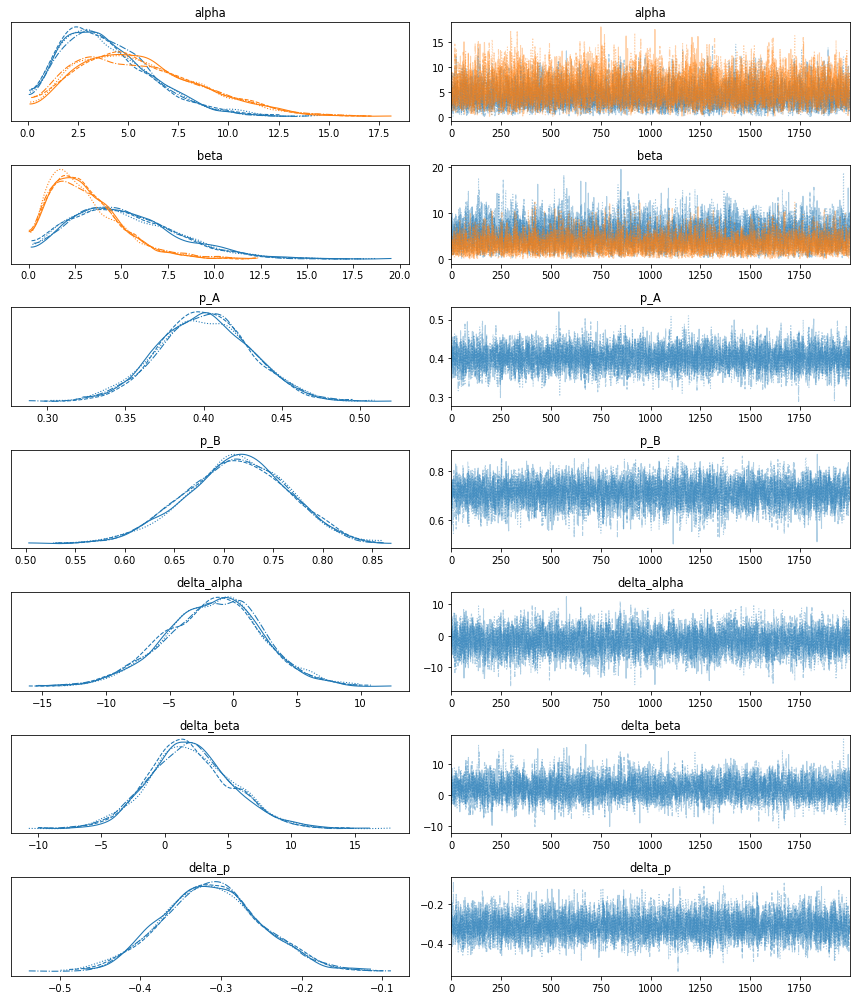

In [146]:
az.plot_trace(trace_4)
plt.tight_layout()
plt.draw()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

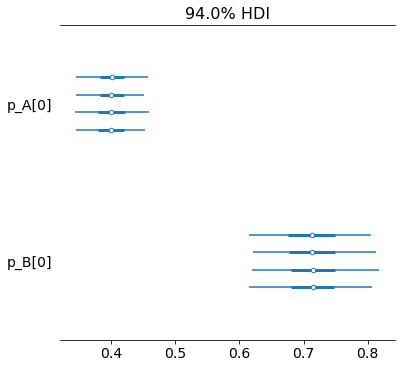

In [147]:
az.plot_forest(trace_4, var_names=['p_A', 'p_B'])

In [148]:
models = {
    'model_1':[model_1, trace_1],
    'model_2':[model_2, trace_2],
    'model_3':[model_3, trace_3],
    'model_4':[model_4, trace_4]
}

# Model comparison
source https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/model_comparison.html

## Leave-one-out Cross-validation (LOO)¶
LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples (without the need for re-fitting the data). This approximation is based on importance sampling. The importance weights are stabilized using a method known as Pareto-smoothed importance sampling (PSIS).

In [149]:
for model in models:
    model_i, trace_i = models[model]
    loo_A = az.loo(trace_i, model_i, var_name='heads_A')
    loo_B = az.loo(trace_i, model_i, var_name='heads_B')
    print(loo_A.loo, loo_B.loo)

-11.846525890891183 -3.4274973692583792
-16.116256089338826 -3.6078989263859356
-15.541670421228094 -3.3914891781306906
-11.822686033881645 -3.492563281625433


/Users/boris.snapir/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/boris.snapir/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:842: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  warnings.warn(
/Users/boris.snapir/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider us

ArviZ includes two convenience functions to help compare LOO for different models. The first of these functions is compare, which computes LOO from a set of traces and models and returns a DataFrame.



In [150]:
df_comp_loo_A

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale,var
model_4,0,-14.461003,1.172332,0.000000,1.000000e+00,1.383033,0.000000,False,log,heads_A
model_1,1,-14.470114,1.181640,0.009111,0.000000e+00,1.394905,0.017522,False,log,heads_A
model_3,2,-15.542360,3.005871,1.081358,1.498972e-16,0.477122,1.139607,True,log,heads_A
model_2,3,-16.210396,3.576217,1.749393,0.000000e+00,0.426191,1.184667,True,log,heads_A


In [151]:
df_comp_loo_A = az.compare({k:models[k][1] for k in models.keys()}, var_name='heads_A')
df_comp_loo_A['var'] = 'heads_A'
df_comp_loo_B = az.compare({k:models[k][1] for k in models.keys()}, var_name='heads_B')
df_comp_loo_B['var'] = 'heads_B'
df_comp_loo = pd.concat([df_comp_loo_A, df_comp_loo_B], ignore_index=False)
df_comp_loo

/Users/boris.snapir/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/boris.snapir/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/boris.s

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale,var
model_4,0,-11.822686,0.197053,0.000000,1.000000e+00,0.283039,0.000000,False,log,heads_A
model_1,1,-11.846526,0.203961,0.023840,1.915135e-15,0.286292,0.007471,False,log,heads_A
model_3,2,-15.541670,3.021964,3.718984,0.000000e+00,0.457979,0.318311,True,log,heads_A
model_2,3,-16.116256,3.418310,4.293570,0.000000e+00,0.233763,0.089951,True,log,heads_A
model_3,0,-3.391489,0.765136,0.000000,1.000000e+00,0.000000,0.000000,True,log,heads_B
model_1,1,-3.427497,0.810331,0.036008,0.000000e+00,0.000000,0.000000,True,log,heads_B
model_4,2,-3.492563,0.859884,0.101074,2.445146e-16,0.000000,0.000000,True,log,heads_B
model_2,3,-3.607899,0.981438,0.216410,0.000000e+00,0.000000,0.000000,True,log,heads_B


- rank, the ranking of the models starting from 0 (best model) to the number of models.

- loo, the values of LOO (or WAIC). The DataFrame is always sorted from best LOO/WAIC to worst.

- p_loo, the value of the penalization term. We can roughly think of this value as the estimated effective number of parameters (but do not take that too seriously).

- d_loo, the relative difference between the value of LOO/WAIC for the top-ranked model and the value of LOO/WAIC for each model. For this reason we will always get a value of 0 for the first model.

- weight, the weights assigned to each model. These weights can be loosely interpreted as the probability of each model being true (among the compared models) given the data.

- se, the standard error for the LOO/WAIC computations. The standard error can be useful to assess the uncertainty of the LOO/WAIC estimates. By default these errors are computed using stacking.

- dse, the standard errors of the difference between two values of LOO/WAIC. The same way that we can compute the standard error for each value of LOO/WAIC, we can compute the standard error of the differences between two values of LOO/WAIC. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about LOO/WAIC is correlated between models. This quantity is always 0 for the top-ranked model.

- warning, If True the computation of LOO/WAIC may not be reliable.

- loo_scale, the scale of the reported values. The default is the log scale as previously mentioned. Other options are deviance – this is the log-score multiplied by -2 (this reverts the order: a lower LOO/WAIC will be better) – and negative-log – this is the log-score multiplied by -1 (as with the deviance scale, a lower value is better).

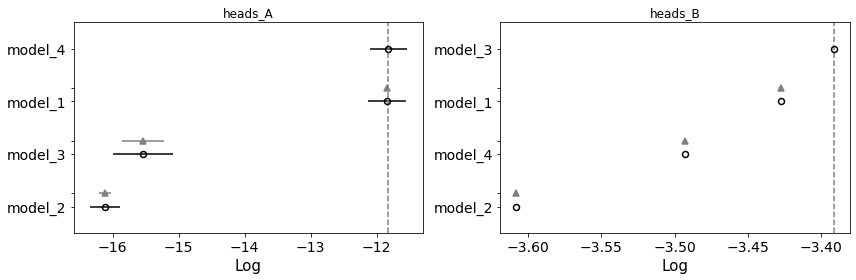

In [152]:
fig, ax = plt.subplots(1,2, figsize=(6*2, 4))
az.plot_compare(df_comp_loo_A, insample_dev=False, ax=ax[0])
az.plot_compare(df_comp_loo_B, insample_dev=False, ax=ax[1])
ax[0].set_title('heads_A')
ax[1].set_title('heads_B')
plt.tight_layout()

# Test on real data from QOS

example with mutinomial https://calogica.com/python/pymc3/2018/11/27/dice-polls-dirichlet-multinomial.html

In [8]:
data = pd.read_csv('data/qos_202204_counts.csv')
data['start_ts_aggr'] = pd.to_datetime(data['start_ts_aggr'])

In [9]:
manufacturer_cols = [c for c in data.columns if c.startswith('manufacturer')]
print(len(manufacturer_cols))
# keep only the main cateagories
totals = data[manufacturer_cols].sum()
manufacturer_cols = totals.index[totals>100].tolist()
manufacturer_cols

39


['manufacturer__amazon',
 'manufacturer__apple',
 'manufacturer__google',
 'manufacturer__lge',
 'manufacturer__motorola',
 'manufacturer__oneplus',
 'manufacturer__samsung',
 'manufacturer__tcl']

In [10]:
data = data[manufacturer_cols+['start_ts_aggr']]
data[manufacturer_cols] = data[manufacturer_cols]+100+np.random.randint(low=-30, high=30, size=data[manufacturer_cols].shape)

We select a set of sessions which are not anomalous and a session which seems anomalous

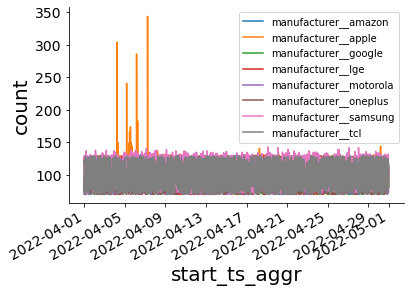

In [11]:
with plot_style(spine_left=True):
    data.set_index('start_ts_aggr').plot(ylabel='count')

In [12]:
# isolate a set of non anomalous sessions
non_anomalous_counts = data.query('(start_ts_aggr>="2022-04-09") and (start_ts_aggr<="2022-04-21")')
non_anomalous_counts = non_anomalous_counts[manufacturer_cols].sample(3).reset_index(drop=True)
display(non_anomalous_counts)
non_anomalous_counts = non_anomalous_counts.values

,manufacturer__amazon,manufacturer__apple,manufacturer__google,manufacturer__lge,manufacturer__motorola,manufacturer__oneplus,manufacturer__samsung,manufacturer__tcl
0,121,81,121,116,108,128,88,79
1,95,118,98,93,92,90,105,75
2,92,82,96,93,105,71,82,122


In [19]:
# isolate one potentially anomalous session
anomalous_counts = data.loc[data['manufacturer__apple']>300, manufacturer_cols].reset_index(drop=True).loc[[0]]
assert len(anomalous_counts)==1
anomalous_counts = anomalous_counts
display(anomalous_counts)
anomalous_counts = anomalous_counts.values

,manufacturer__amazon,manufacturer__apple,manufacturer__google,manufacturer__lge,manufacturer__motorola,manufacturer__oneplus,manufacturer__samsung,manufacturer__tcl
0,85,344,73,83,112,98,90,108


In [20]:
non_anomalous_counts = non_anomalous_counts[:, :5]
anomalous_counts = anomalous_counts[:, :5]
manufacturer_cols = manufacturer_cols[:5]

In [21]:
with pm.Model() as model_1:
    ### machine A
    ## prior p for each manufacturer
    p_A = pm.Dirichlet('p_A', a=np.ones(len(manufacturer_cols))) # non-informative prior

    ## counts for non anomalous sessions
    counts_A = pm.Multinomial('non_anomalous_counts', n=non_anomalous_counts.sum(axis=1), p=p_A, observed=non_anomalous_counts)
    
    ### machine B
    p_B = pm.Dirichlet('p_B', a=np.ones(len(manufacturer_cols))) # non-informative prior
    
    ## counts for potentially anomalous session
    counts_B = pm.Multinomial('anomalous_counts', n=anomalous_counts.sum(axis=1), p=p_B, observed=anomalous_counts)
    
    ## difference between the two coins
    # delta_p = pm.Deterministic('delta_p', p_A-p_B)

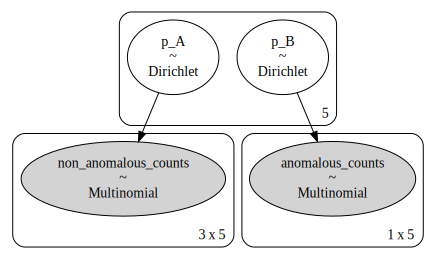

In [22]:
pm.model_to_graphviz(model_1)

In [23]:
with model_1:
    trace_1 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_A, p_B]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 27 seconds.


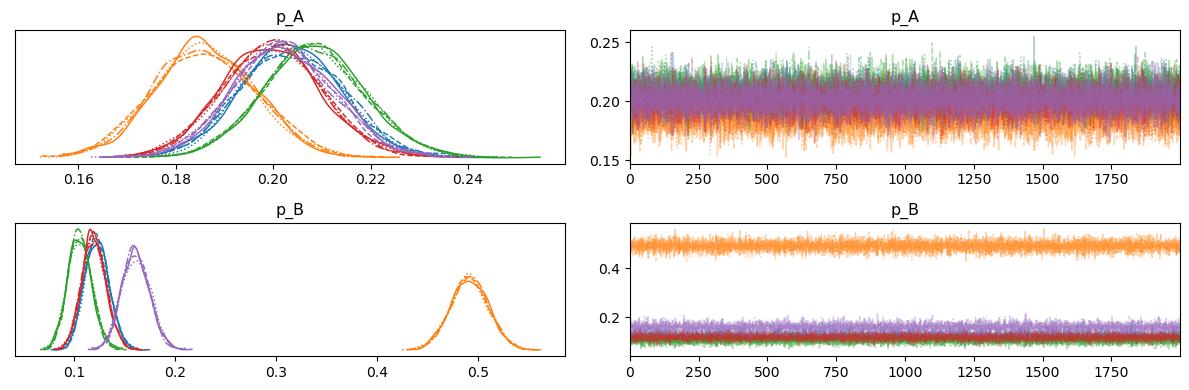

In [24]:
az.plot_trace(trace_1)
plt.tight_layout()
plt.draw()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

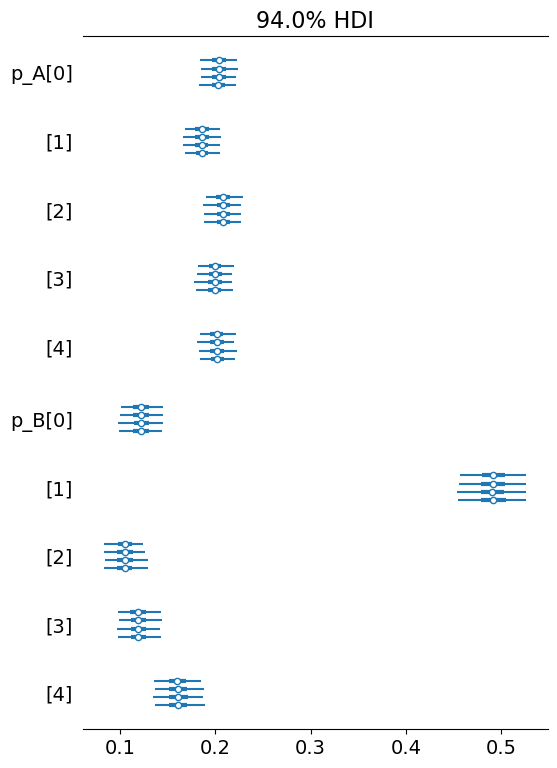

In [25]:
az.plot_forest(trace_1, var_names=['p_A', 'p_B'])

In [26]:
with pm.Model() as model_2:
    ### machine A
    ## prior p for each manufacturer
    p_A = pm.Dirichlet('p_A', a=np.ones(len(manufacturer_cols)), shape=non_anomalous_counts.shape) # non-informative prior

    ## counts for non anomalous sessions
    counts_A = pm.Multinomial('non_anomalous_counts', n=non_anomalous_counts.sum(axis=1), p=p_A, observed=non_anomalous_counts)
    
    ### machine B
    p_B = pm.Dirichlet('p_B', a=np.ones(len(manufacturer_cols)), shape=anomalous_counts.shape) # non-informative prior
    
    ## counts for potentially anomalous session
    counts_B = pm.Multinomial('anomalous_counts', n=anomalous_counts.sum(axis=1), p=p_B, observed=anomalous_counts)
    
    ## difference between the two coins
    # delta_p = pm.Deterministic('delta_p', p_A-p_B)

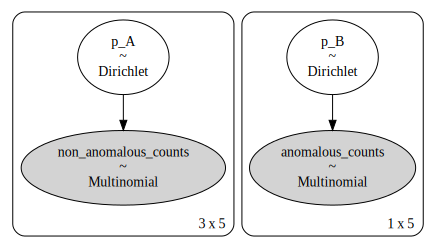

In [27]:
pm.model_to_graphviz(model_2)

In [28]:
with model_2:
    trace_2 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_A, p_B]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 33 seconds.


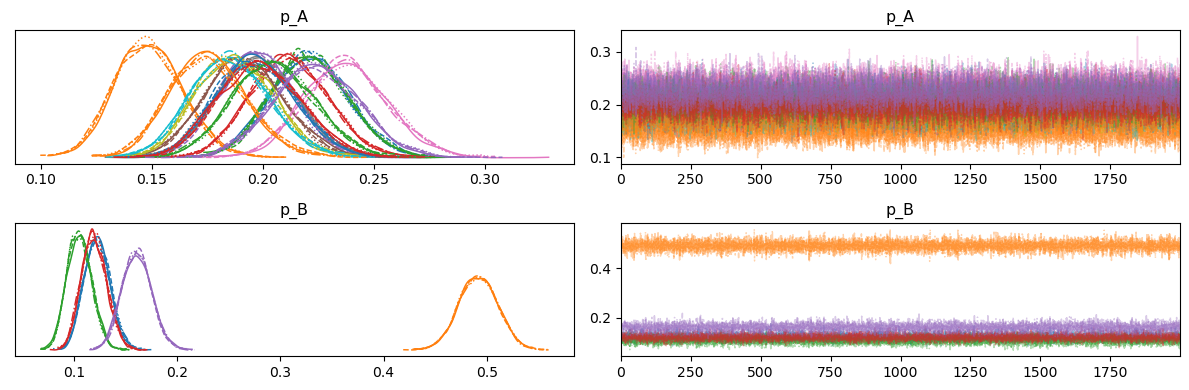

In [29]:
az.plot_trace(trace_2)
plt.tight_layout()
plt.draw()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

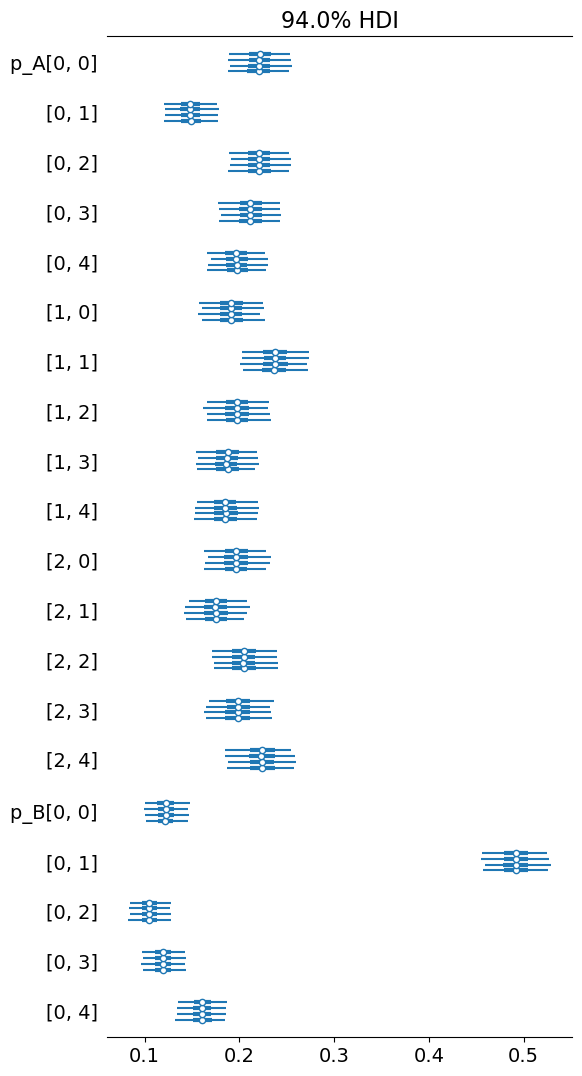

In [30]:
az.plot_forest(trace_2, var_names=['p_A', 'p_B'])

In [34]:
 # read this for hyperprior
 #    https://stats.stackexchange.com/questions/44144/multinomial-dirichlet-model-with-hyperprior-distribution-on-the-concentration-pa


with pm.Model() as model_3:
    ## hyperpriors for machine A and machine B
    a = pm.Gamma('a', alpha=1, beta=0.5, shape=(2,5))
    
    ### machine A
    ## prior p for each manufacturer
    p_A = pm.Dirichlet('p_A', a=a[0], shape=non_anomalous_counts.shape) # non-informative prior

    ## counts for non anomalous sessions
    counts_A = pm.Multinomial('non_anomalous_counts', n=non_anomalous_counts.sum(axis=1), p=p_A, observed=non_anomalous_counts)
    
    ### machine B
    p_B = pm.Dirichlet('p_B', a=a[1], shape=anomalous_counts.shape) # non-informative prior
    
    ## counts for potentially anomalous session
    counts_B = pm.Multinomial('anomalous_counts', n=anomalous_counts.sum(axis=1), p=p_B, observed=anomalous_counts)
    
    ## difference between the two coins
    # delta_p = pm.Deterministic('delta_p', p_A-p_B)

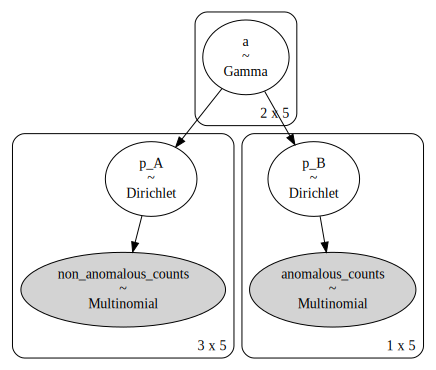

In [35]:
pm.model_to_graphviz(model_3)

In [36]:
with model_3:
    trace_3 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, p_A, p_B]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 39 seconds.


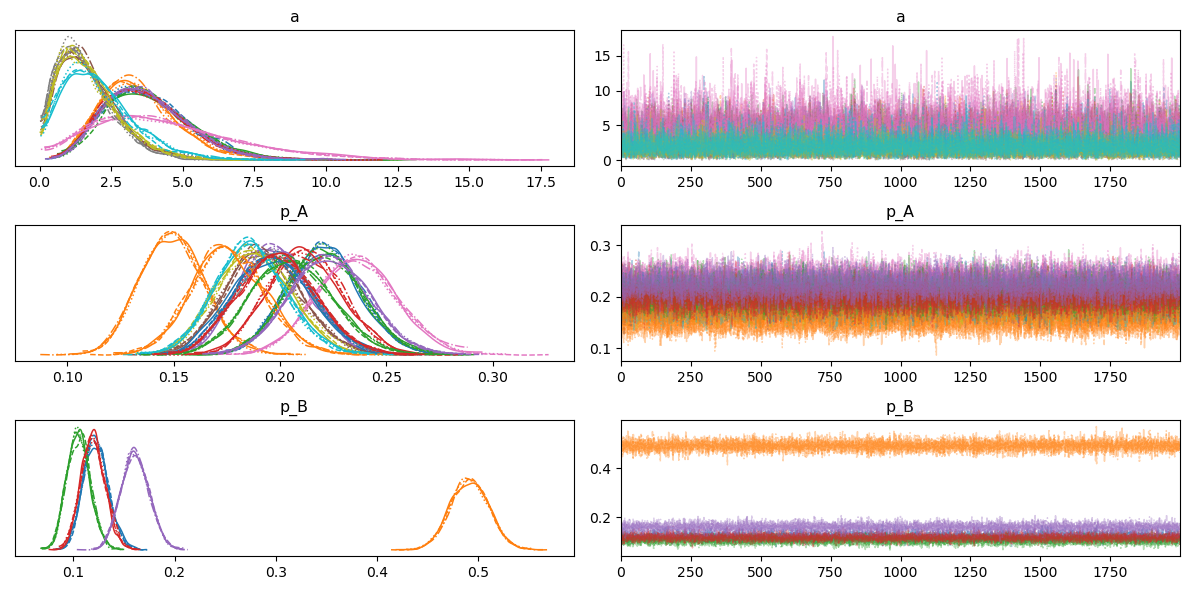

In [37]:
az.plot_trace(trace_3)
plt.tight_layout()
plt.draw()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

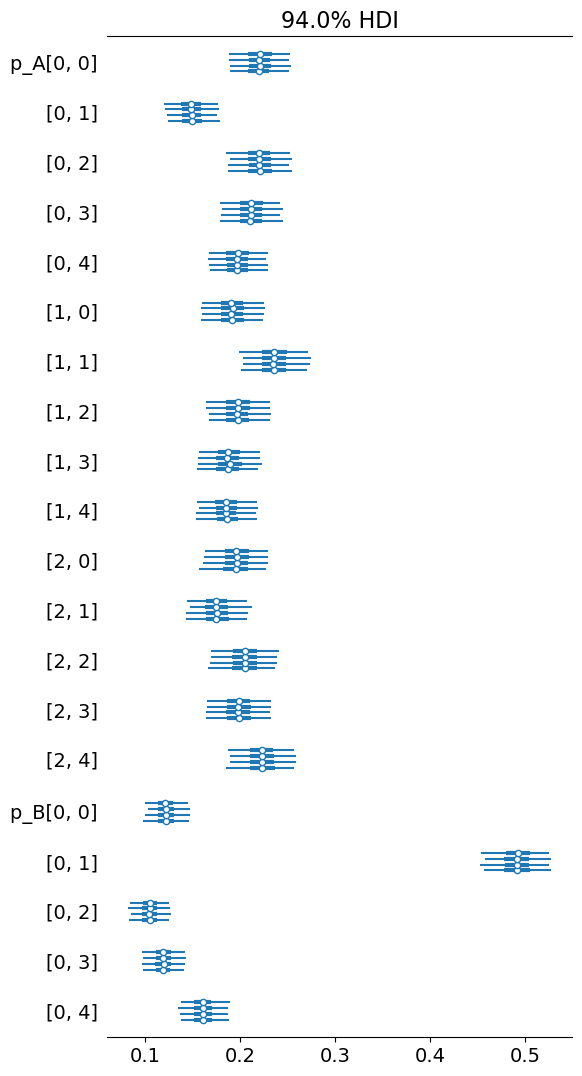

In [38]:
az.plot_forest(trace_3, var_names=['p_A', 'p_B'])

In [39]:
with pm.Model() as model_4:
    ## hyperpriors for machine A and machine B
    a = pm.Gamma('a', alpha=1, beta=0.5, shape=(2,5))
    
    ### machine A
    ## prior p for each manufacturer
    p_A = pm.Dirichlet('p_A', a=a[0], shape=(1,5)) # non-informative prior

    ## counts for non anomalous sessions
    counts_A = pm.Multinomial('non_anomalous_counts', n=non_anomalous_counts.sum(axis=1), p=p_A, observed=non_anomalous_counts)
    
    ### machine B
    p_B = pm.Dirichlet('p_B', a=a[1], shape=anomalous_counts.shape) # non-informative prior
    
    ## counts for potentially anomalous session
    counts_B = pm.Multinomial('anomalous_counts', n=anomalous_counts.sum(axis=1), p=p_B, observed=anomalous_counts)
    
    ## difference between the two coins
    # delta_p = pm.Deterministic('delta_p', p_A-p_B)

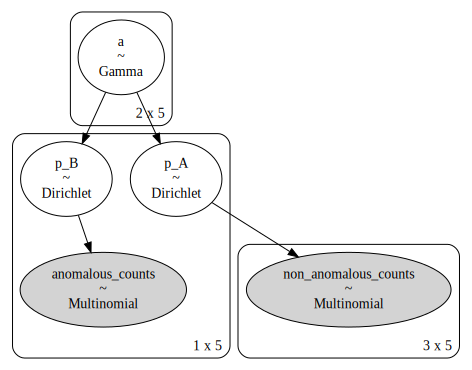

In [40]:
pm.model_to_graphviz(model_4)

In [41]:
with model_4:
    trace_4 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, p_A, p_B]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


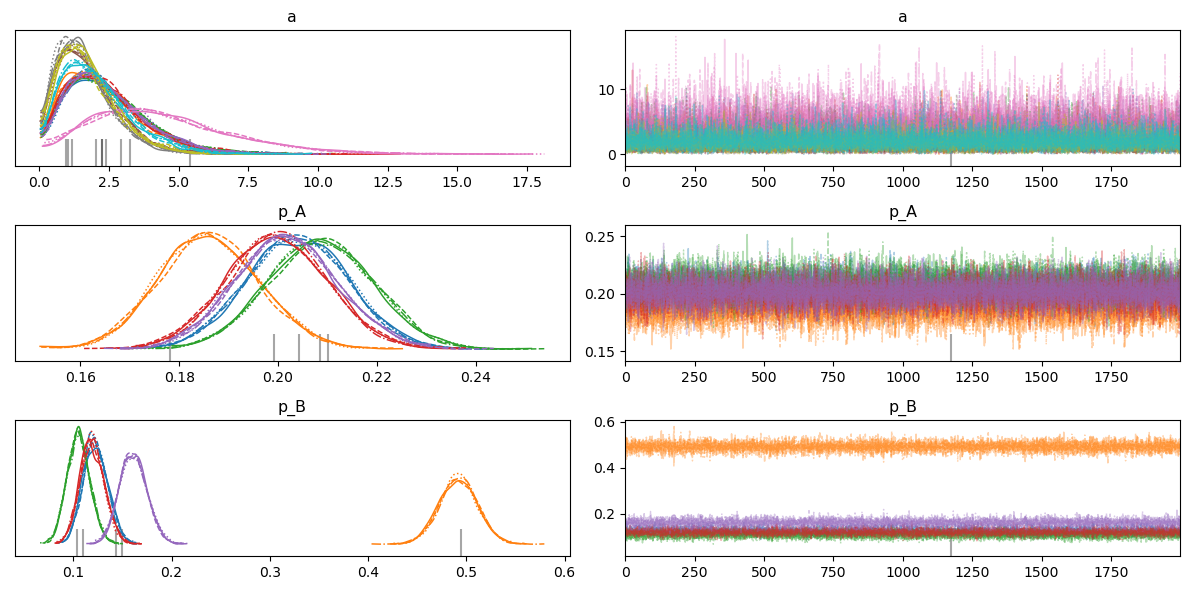

In [42]:
az.plot_trace(trace_4)
plt.tight_layout()
plt.draw()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

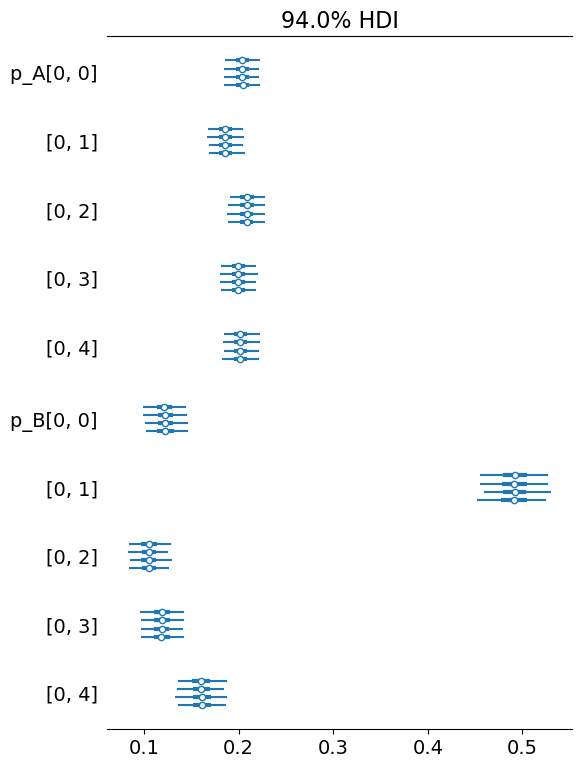

In [43]:
az.plot_forest(trace_4, var_names=['p_A', 'p_B'])

In [44]:
models = {
    'model_1': [model_1, trace_1],
    'model_2': [model_2, trace_2],
    'model_3': [model_3, trace_3],
    'model_4': [model_4, trace_4]
}

In [45]:
for model in models:
    model_i, trace_i = models[model]
    loo_A = az.loo(trace_i, model_i, var_name='non_anomalous_counts')
    loo_B = az.loo(trace_i, model_i, var_name='anomalous_counts')
    print(loo_A.loo, loo_B.loo)

-50.78966737003533 -16.34604895000154
-49.29472025520514 -16.370592217881033
-48.631077929133724 -17.30592421496955
-50.791732507207435 -16.925891075765342


/Users/boris.snapir/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/boris.snapir/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/boris.s

In [46]:
df_comp_loo_A = az.compare({k:models[k][1] for k in models.keys()}, var_name='non_anomalous_counts')
df_comp_loo_A['var'] = 'non_anomalous_counts'
df_comp_loo_B = az.compare({k:models[k][1] for k in models.keys()}, var_name='anomalous_counts')
df_comp_loo_B['var'] = 'anomalous_counts'
df_comp_loo = pd.concat([df_comp_loo_A, df_comp_loo_B], ignore_index=False)
df_comp_loo

/Users/boris.snapir/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/boris.snapir/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/boris.s

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale,var
model_3,0,-48.631078,8.272941,0.000000,6.892803e-01,0.275661,0.000000,True,log,non_anomalous_counts
model_2,1,-49.294720,8.911110,0.663642,0.000000e+00,0.677491,0.631631,True,log,non_anomalous_counts
model_1,2,-50.789667,6.897212,2.158589,1.043223e-17,3.884744,3.670338,True,log,non_anomalous_counts
model_4,3,-50.791733,6.863144,2.160655,3.107197e-01,3.987260,3.782640,True,log,non_anomalous_counts
model_1,0,-16.346049,2.711319,0.000000,1.000000e+00,0.000000,0.000000,True,log,anomalous_counts
model_2,1,-16.370592,2.697364,0.024543,0.000000e+00,0.000000,0.000000,True,log,anomalous_counts
model_4,2,-16.925891,3.277135,0.579842,9.171526e-17,0.000000,0.000000,True,log,anomalous_counts
model_3,3,-17.305924,3.682303,0.959875,0.000000e+00,0.000000,0.000000,True,log,anomalous_counts


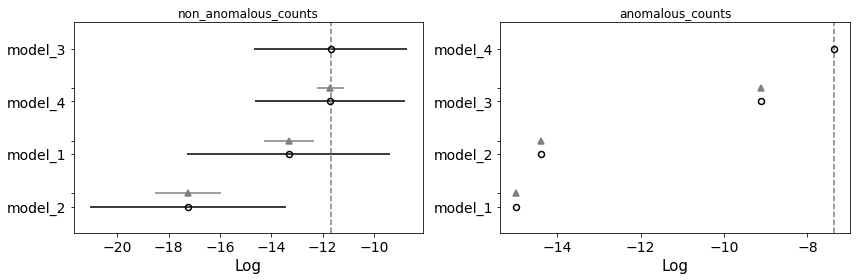

In [316]:
fig, ax = plt.subplots(1,2, figsize=(6*2, 4))
az.plot_compare(df_comp_loo_A, insample_dev=False, ax=ax[0])
az.plot_compare(df_comp_loo_B, insample_dev=False, ax=ax[1])
ax[0].set_title('non_anomalous_counts')
ax[1].set_title('anomalous_counts')
plt.tight_layout()

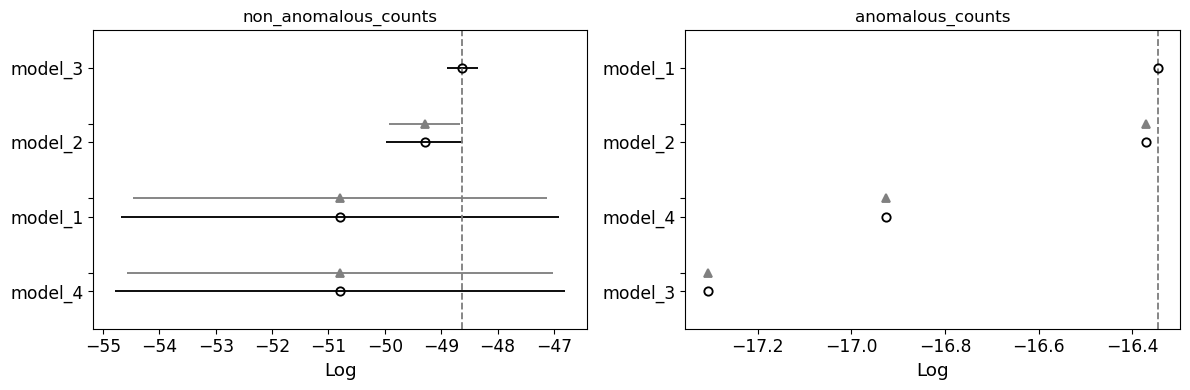

In [47]:
fig, ax = plt.subplots(1,2, figsize=(6*2, 4))
az.plot_compare(df_comp_loo_A, insample_dev=False, ax=ax[0])
az.plot_compare(df_comp_loo_B, insample_dev=False, ax=ax[1])
ax[0].set_title('non_anomalous_counts')
ax[1].set_title('anomalous_counts')
plt.tight_layout()